<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_044_class_1_precision_model_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


### Prior Performance Metrics

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame
file_path = '/content/combined_model_metrics_with_resampling.csv'
data = pd.read_csv(file_path)
data

,Model,Experiment,Recall_0,Precision_0,F1_0,Recall_1,Precision_1,F1_1,F1_Macro,Accuracy
0,Logistic Regression,baseline,0.969399,0.818724,0.887713,0.244160,0.693790,0.361204,0.624459,0.809000
1,Random Forest,baseline,0.939225,0.839679,0.886667,0.368500,0.632600,0.465714,0.676190,0.813000
2,HistGradientBoosting,baseline,0.942863,0.840198,0.888575,0.368500,0.646825,0.469515,0.679045,0.815833
3,LGBM,baseline,0.947143,0.840486,0.890633,0.366993,0.663488,0.472586,0.681609,0.818833
4,Logistic Regression,class_weight_balanced,0.691419,0.868782,0.770019,0.632253,0.367821,0.465078,0.617548,0.678333
5,Random Forest,class_weight_balanced,0.947143,0.835094,0.887597,0.341372,0.647143,0.446966,0.667281,0.813167
6,HistGradientBoosting,class_weight_balanced,0.942863,0.840198,0.888575,0.368500,0.646825,0.469515,0.679045,0.815833
7,LGBM,class_weight_balanced,0.799700,0.880122,0.837986,0.616428,0.466363,0.530996,0.684491,0.759167
8,Logistic Regression (SMOTE),resampling,0.677509,0.867160,0.760692,0.634514,0.358450,0.458107,0.609399,0.668000
9,Random Forest (SMOTE),resampling,0.890434,0.854941,0.872327,0.467973,0.548102,0.504878,0.688603,0.797000


### Top Models

In [4]:
# Get the top 3 models for Precision_1
top_3_precision_1 = data[['Model', 'Experiment', 'Recall_1', 'Precision_1']].sort_values(by='Precision_1', ascending=False).head(3)

print("\nTop 3 Models by Precision (Class 1):")
print(top_3_precision_1)


Top 3 Models by Precision (Class 1):
                 Model             Experiment  Recall_1  Precision_1
0  Logistic Regression               baseline  0.244160     0.693790
3                 LGBM               baseline  0.366993     0.663488
5        Random Forest  class_weight_balanced  0.341372     0.647143


### Load & Preprocess

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import warnings
from loan_data_utils import load_and_preprocess_data

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])


### Logistic Regression Tuning

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from loan_data_utils import evaluate_model

# Define the hyperparameter grid for Logistic Regression
param_grid_lr = {
    'classifier__C': np.linspace(10,20, 5),
    'classifier__solver': ['liblinear'], # 'lbfgs', 'saga'
    'classifier__penalty': ['l2', 'l2']
}

# Logistic Regression Pipeline
pipeline_lr = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Setup GridSearchCV for Logistic Regression
grid_lr = GridSearchCV(pipeline_lr, param_grid=param_grid_lr, scoring='precision', cv=5)

# Fit the model
grid_lr.fit(X_train, y_train)

# Get the best model and its parameters
best_lr = grid_lr.best_estimator_
best_params_lr = grid_lr.best_params_
print("Best Logistic Regression Parameters:", best_params_lr)

# Evaluate the best model
evaluation_results_lr = evaluate_model(best_lr, X_train, X_test, y_train, y_test, 'Logistic Regression', 'Class 1 Precision')
print("\nLogistic Regression - Best Model Evaluation:")
print(evaluation_results_lr)



Best Logistic Regression Parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Logistic Regression - Best Model Evaluation:
{'Model': 'Logistic Regression', 'Experiment': 'Class 1 Precision', 'Recall_0': 0.9691846779370854, 'Precision_0': 0.8186912509038322, 'F1_0': 0.8876041156295934, 'Recall_1': 0.24415975885455915, 'Precision_1': 0.6923076923076923, 'F1_1': 0.36100278551532033, 'F1_Macro': 0.6243034505724568, 'Accuracy': 0.8088333333333333}


#### Plot Params

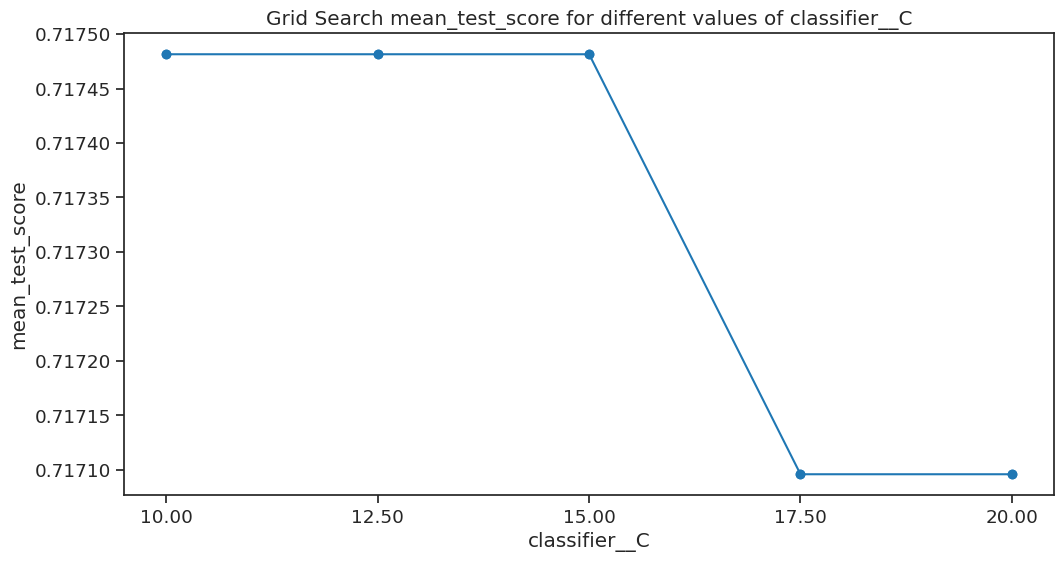

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract the results from GridSearchCV
results = grid_lr.cv_results_

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Function to plot line charts of grid search results
def plot_simple_line_chart_grid_search(results_df, param, score='mean_test_score'):
    plt.figure(figsize=(12, 6))
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("ticks")

    # Extract the values of the specified parameter
    unique_params = results_df[f'param_{param}'].unique()

    # Ensure that the parameter values are numeric
    unique_params = np.array(unique_params, dtype=float)

    # Plot the results
    plt.plot(results_df[f'param_{param}'].astype(float), results_df[score], marker='o')

    plt.title(f'Grid Search {score} for different values of {param}')
    plt.xlabel(param)
    plt.ylabel(score)
    plt.xticks(unique_params, labels=[f'{param:.2f}' for param in unique_params])  # Format x-ticks to 2 decimals
    plt.show()

# Example usage
plot_simple_line_chart_grid_search(results_df, 'classifier__C', score='mean_test_score')

### LGBM Tuning

In [21]:
from lightgbm import LGBMClassifier

# Define the hyperparameter grid for LGBM
param_grid_lgbm = {
    'classifier__num_leaves': [31, 50, 70],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [100, 200, 300]
}

# LGBM Pipeline
pipeline_lgbm = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, force_col_wise=True))
])

# Setup GridSearchCV for LGBM
grid_lgbm = GridSearchCV(pipeline_lgbm, param_grid=param_grid_lgbm, scoring='precision', cv=5)

# Fit the model
grid_lgbm.fit(X_train, y_train)

# Get the best model and its parameters
best_lgbm = grid_lgbm.best_estimator_
best_params_lgbm = grid_lgbm.best_params_
print("Best LGBM Parameters:", best_params_lgbm)

# Evaluate the best model
evaluation_results_lgbm = evaluate_model(best_lgbm, X_train, X_test, y_train, y_test, 'LGBM', 'Class 1 Precision')
print("\nLGBM - Best Model Evaluation:")
print(evaluation_results_lgbm)


[LightGBM] [Info] Number of positive: 4248, number of negative: 14952
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221250 -> initscore=-1.258397
[LightGBM] [Info] Start training from score -1.258397
[LightGBM] [Info] Number of positive: 4247, number of negative: 14953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221198 -> initscore=-1.258699
[Lig

#### Plot Params

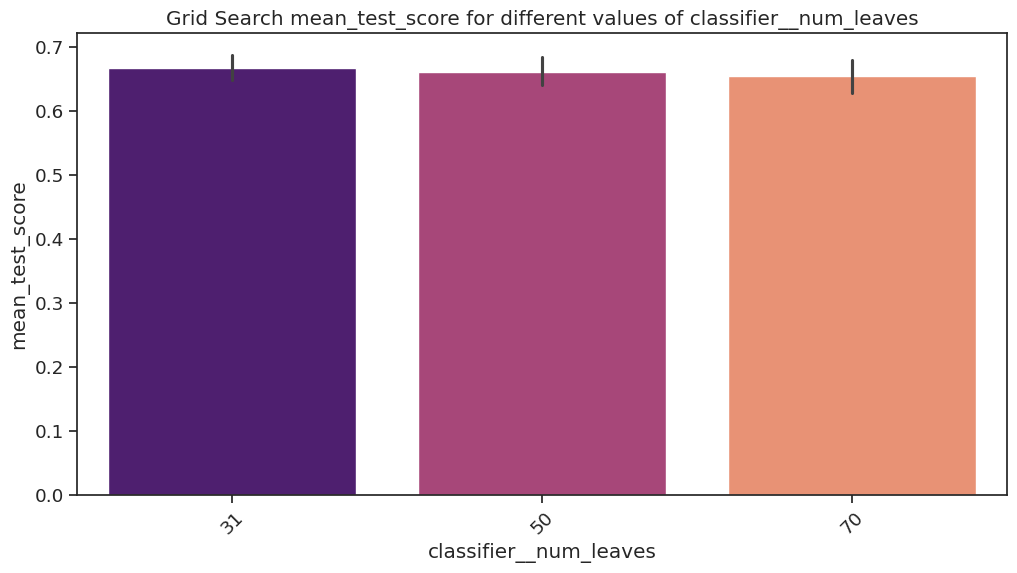

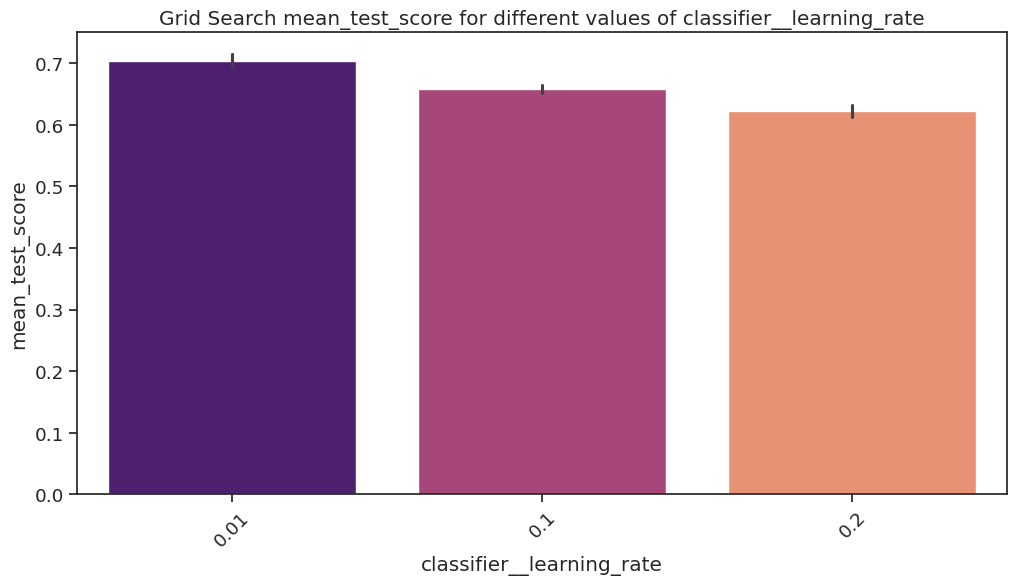

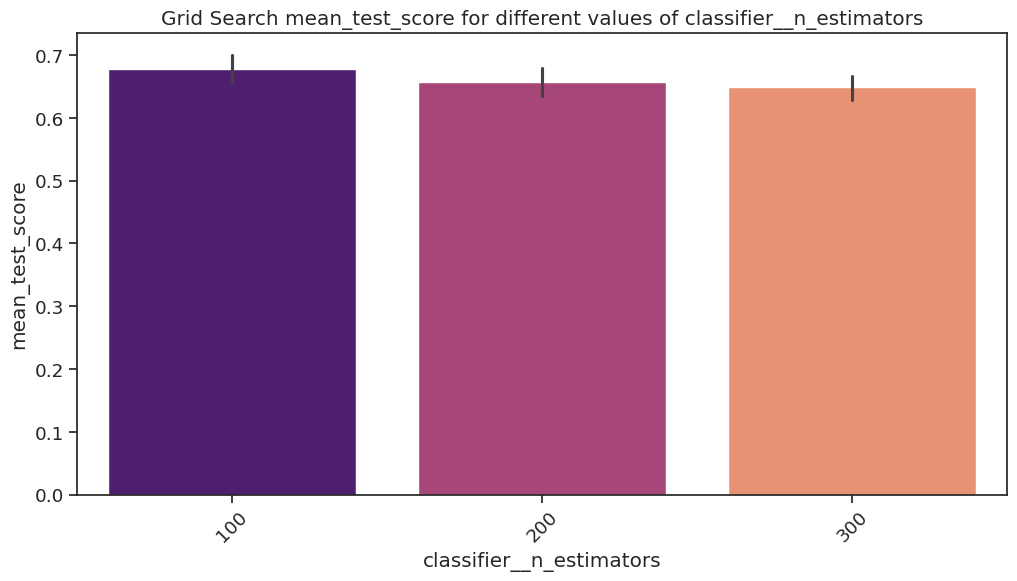

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract the results from GridSearchCV
results = grid_lgbm.cv_results_

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Function to plot bar charts of grid search results
def plot_grid_search_results(results_df, param, score='mean_test_score'):
    plt.figure(figsize=(12, 6))
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("ticks")

    # Extract the values of the specified parameter
    param_values = results_df[f'param_{param}'].astype(str)

    # Plot the results
    sns.barplot(x=param_values, y=results_df[score], hue=param_values, palette='magma')

    plt.title(f'Grid Search {score} for different values of {param}')
    plt.xlabel(param)
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Example usage for LGBM parameters
plot_grid_search_results(results_df, 'classifier__num_leaves', score='mean_test_score')
plot_grid_search_results(results_df, 'classifier__learning_rate', score='mean_test_score')
plot_grid_search_results(results_df, 'classifier__n_estimators', score='mean_test_score')


### Random Forest Tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# Random Forest Pipeline
pipeline_rf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Setup GridSearchCV for Random Forest
grid_rf = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, scoring='precision', cv=5)

# Fit the model
grid_rf.fit(X_train, y_train)

# Get the best model and its parameters
best_rf = grid_rf.best_estimator_
best_params_rf = grid_rf.best_params_
print("Best Random Forest Parameters:", best_params_rf)

# Evaluate the best model
evaluation_results_rf = evaluate_model(best_rf, X_train, X_test, y_train, y_test, 'Random Forest', 'Class 1 Precision')
print("\nRandom Forest - Best Model Evaluation:")
print(evaluation_results_rf)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract the results from GridSearchCV
results = grid_rf.cv_results_

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Function to plot bar charts of grid search results
def plot_grid_search_results(results_df, param, score='mean_test_score'):
    plt.figure(figsize=(12, 6))
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("ticks")

    # Extract the values of the specified parameter
    param_values = results_df[f'param_{param}'].astype(str)

    # Plot the results
    sns.barplot(x=param_values, y=results_df[score], hue=results_df[score], palette='magma')

    plt.title(f'Grid Search {score} for different values of {param}')
    plt.xlabel(param)
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Example usage for Random Forest parameters
plot_grid_search_results(results_df, 'classifier__n_estimators', score='mean_test_score')
plot_grid_search_results(results_df, 'classifier__max_depth', score='mean_test_score')
plot_grid_search_results(results_df, 'classifier__min_samples_split', score='mean_test_score')


### Append Results to Top Model Params File

In [ ]:
import json

# Load existing parameters
with open('/content/top_model_params.json', 'r') as f:
    top_model_params = json.load(f)

# Update the top models and parameters with the new tuning results
top_model_params["Class 1 Precision"] = {
    "Logistic Regression (ADASYN)": {
        "best_params": best_params_lr,
    },
    "LGBM (ADASYN)": {
        "best_params": best_params_lgbm,
    },
    "Random Forest (ADASYN)": {
        "best_params": best_params_rf,
    }
}

# Save the updated top model parameters to the JSON file
with open('/content/top_model_params.json', 'w') as f:
    json.dump(top_model_params, f, indent=4)

# Load the saved parameters
with open('/content/top_model_params.json', 'r') as f:
    top_model_params = json.load(f)

# Loop through the parameters and print them
for category, models in top_model_params.items():
    print(f"Category: {category}")
    for model_name, params in models.items():
        print(f"  Model: {model_name}")
        print(f"    Best Params: {params['best_params']}")
        print(f"    Threshold: {params['threshold']}")